# Evaluation of enthalpy to temperature conversion methods

This notebook compares different methods for the conversion of enthalpy to temperature.
The evaluation is performed in terms of computational cost and accuracy.

The following methods are considered:
- **Newton**
  
    Newton's method is an iterative algorithm for finding a root of a function $f(x)$, starting from an initial guess.  
    The iterative formula to update the guess root is:

    $$
    x_{n+1} = x_{n} - \frac{f(x_{n})}{f'(x_{n})},
    $$

    where subscrits $n$ and $n+1$ refer, in the order, to the old and new iterations. 

    To find the temperature $T_{i+1}$ corresponding to a known enthalpy rise $\Delta{h_{i, i+1}}$, 
    from the $i-th$ to the $(i+1)-th$ state, the following function is considered:

    $$
    f(T_{i+1}) = \Delta{h_{i, i+1}} - \Delta{h}^*(T_{i+1}),
    $$

    where $\Delta{h}^*(T_{i+1})$ is the result of a correlation function expressed in terms of $T_{i+1}$.

    The iteration formula is then:

    $$
    T_{i+1, n+1} = T_{i+1, n} + \frac{\Delta{h_{i,i+1} - \Delta{h}^*(T_{i+1, n})}}{c_p(T_{i+1, n})}.
    $$

- **_lbh15_**

    _lbh15_ is a python-based library for Lead, Bismuth and LBE thermophysical and thermochemical properties. Given a certain temperature $T$, _lbh15_ implements a correlation to find the corresponding $\Delta{h}(T)$, which is computed with respect to the melting state of the corresponding liquid metal. 

- **Table interpolation**

    This method relies on the _NumPy_ function `interp()` to perform linear interpolation. It reads a reference dataset provided from a _csv_ file containing a table that reports the enthalpies for specific temperature values: enthalpy values are defined with respect to the melting temperature of the liquid metal. 

- **Fitting polynomial**
  
    A polynomial is built from the same dataset as that used in the method above, using the _NumPy_ functions `polyfit` and `polyval`.

    Using `polyval` is more efficient than defining a dedicated function with an algebraic relation, because the _NumPy_ function is based on the Horner scheme. 

## Evaluation of the identified methods
The methods described above are implemented in the file _temp_from_h.py_, and imported in the following code section. 

Their computational effort and accuracy is evaluated with the `eval_time` and `eval_accuracy` functions, imported from the file _time_and_accuracy.py_.

In [ ]:
from temp_from_h import newton_method, lbh15_method, table_method, poly_method
from time_and_accuracy import eval_time, eval_accuracy, table_method_summary
from plots import plot_table_evaluation, plot_polynomium_results, \
    plot_accuracy_comparison
from _commons import DB_SIZES, DEG, DB_PATH_SUFFIX, DB_PATH_PREFIX
import numpy as np 
from tabulate import tabulate
import os

reference = np.genfromtxt(os.path.join('data','lead_ref.csv'), delimiter=',')

In the following sections, the accuracy of the _Table Interpolation_ method is first examined. Datasets of varying sizes (ranging from 500 to 5000 rows) are used as the basis for interpolation, aiming to identify the optimal compromise between dataset size, computational effort, and accuracy. Accuracy is estimated against the reference dataset contained in _lead_ref.csv_. The reference dataset is constructed using _lbh15_ and contains 5000 temperature-enthalpy couples. 

Polynomials of varying degrees are then constructed to determine which degree provides the best fit to the table data.

Once the optimal dataset for the _Table Interpolation_ method and the optimal degree for the _Polynomial fitting_ method have been identified, the comparison is extended to the _Newton’s_ and _lbh15_ methods, first in terms of computational effort and then in terms of accuracy.

## Table interpolation accuracy
The accuracy of the table method depends on the width of the dataset used for interpolation. Smaller temperature increments between consecutive data points generally lead to higher interpolation accuracy. To evaluate how accuracy is influenced by the amount of data, different datasets (collecting from 500 to 5000 temperature-enthalpy couples) have been created and are compared in terms of computational effort and accuracy against a reference dataset of 5000 points. The 5000 points datasets used for building the interpolation and for calculating the accuracy are different: temperature values are obtained over slightly different variation ranges.

In [8]:
results_table = {}

for s in DB_SIZES:
    results_table[s] = table_method_summary(reference, s)   

Below the resulting accuracy and computational effort for `table_method`:

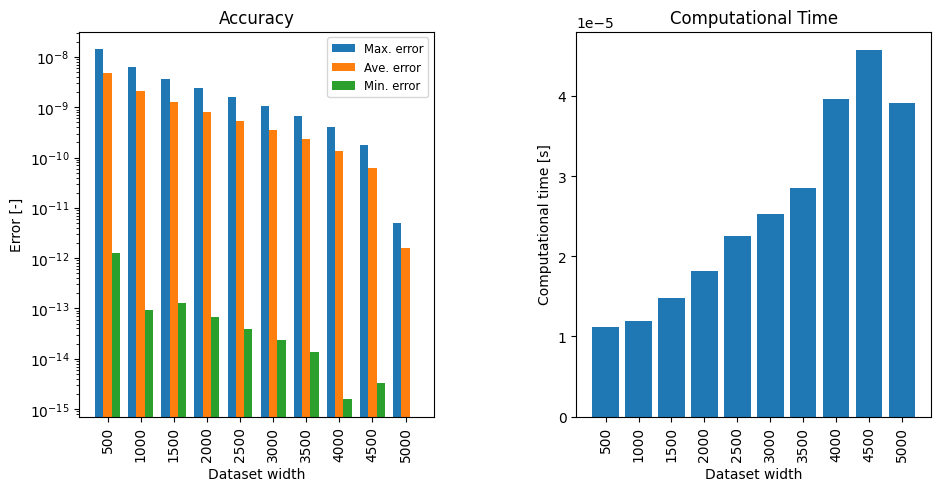

In [9]:
plot_table_evaluation(results_table)

The largest dataset (5000 data) provides the best accuracy with limited computational effort. This dataset will be hereafter used as the base for interpolation in the _Table interpolation_ method. 

## Fitting polynomial
In this section, a polynomial is built fitting a dataset of 5000 temperature-enthalpy couples. The _NumPy_ functions `polyfit` and `polyval` are used. 

According to the `numpy.polyfit` documentation page (https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), the polynomial coefficients' fitting may be badly conditioned when the degree of the polynomial is large. When this happens, a _RankWarning_ is issued.

/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/925344575.py:10: RankWarning: Polyfit may be poorly conditioned
  coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
/tmp/ipykernel_7212/

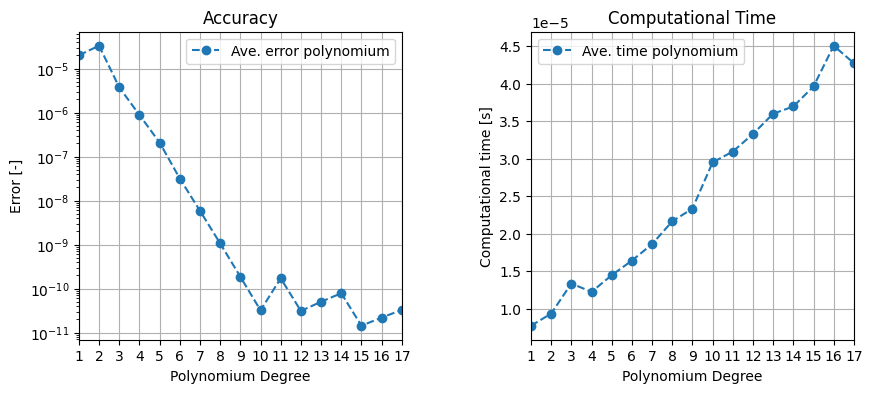

In [10]:
s = DB_SIZES[-1]
data_path = DB_PATH_PREFIX + str(s) + DB_PATH_SUFFIX

data = np.genfromtxt(os.path.join('data', data_path), delimiter=',')

poly_results = {'eave_poly': np.array([]),
                'time_poly': np.array([])}

for dd in range(1, DEG):
    coeffs_T2h = np.polyfit(data[:,0], data[:,1], deg=dd)
    coeffs_h2T = np.polyfit(data[:,1], data[:,0], deg=dd)
    
    errors = eval_accuracy(poly_method, reference, coeffs_T2h=coeffs_T2h, 
                           coeffs_h2T=coeffs_h2T)
    poly_results['eave_poly'] = np.append(poly_results['eave_poly'], 
                                        np.mean(errors))
    poly_results['time_poly'] = np.append(poly_results['time_poly'], 
                                        eval_time(poly_method, 
                                        coeffs_T2h=coeffs_T2h, 
                                        coeffs_h2T=coeffs_h2T))

plot_polynomium_results(poly_results)

_NumPy_ issues a _RankWarning_ for polynomials of degree >= 11. As a consequence, the 10-th degree polynomial will be hereafter considered as the most accurate and reliable.

## Computational effort

The average computational time is estimated for all the considered methods. 

Each method requires an array of temperatures and an array of enthalpy rises. For the scope of this analysis a temperature of 700 K and an enthalpy rise of 100 J/kg are used.

The largest dataset for interpolation has been used for the Table interpolation method and for the polynomial fitting.

In [11]:
data_path = DB_PATH_PREFIX + str(DB_SIZES[-1]) + DB_PATH_SUFFIX
table = [["Newton", eval_time(newton_method)],
         ["lbh15", eval_time(lbh15_method)],
         ["Table", results_table[DB_SIZES[-1]]['time']],
         ["Polynomium (10 deg)", poly_results['time_poly'][9]]]

print(tabulate(table, headers=["Method", "Computational effort [s]"], 
               tablefmt="github"))

| Method              |   Computational effort [s] |
|---------------------|----------------------------|
| Newton              |                0.000314622 |
| lbh15               |                0.01346     |
| Table               |                3.91655e-05 |
| Polynomium (10 deg) |                2.94994e-05 |


## Accuracy evaluation

A vector of $n$ temperatures `tt_ref` is created to test the accuracy of the _Newton's_, _Table interpolation_ and _Polynomial fitting_ methods.
For each pair of consecutive elements in `tt_ref` ($T_i$ and $T_{i+1}$), the corresponding enthalpy rise $\Delta h(T_i, T_{i+1})$ is calculated with _lbh15_, producing a vector of $n-1$ enthalpy values `hh_ref`.

`tt_ref` and `hh_ref` vectors are passed as parameters to the three above-mentioned methods. The results are compared with `tt_ref` vector, which also serves as a reference.

In the following code snippet, the accuracy of the methods is evaluated against a 5000 points reference dataset already used in the _Table accuracy_ section. 

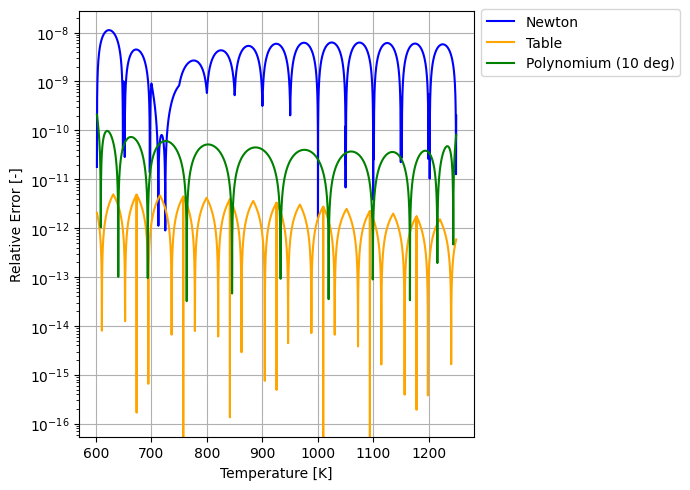

In [30]:
path = DB_PATH_PREFIX + str(DB_SIZES[-1]) + DB_PATH_SUFFIX
err_newton = eval_accuracy(newton_method, reference)
err_table = eval_accuracy(table_method, reference, data_path=path)
err_poly = eval_accuracy(poly_method, reference, 
                           coeffs_T2h=np.polyfit(data[:,0], data[:,1], deg=10), 
                           coeffs_h2T=np.polyfit(data[:,1], data[:,0], deg=10))
plot_accuracy_comparison(reference, err_newton, err_table, err_poly)

# Conclusions

The following methods for converting enthalpy to temperature were compared: _Newton's_ method, _lbh15_, _Table interpolation_ (based on the _NumPy_ function `interp`), and _Polynomial fitting_ (based on the _NumPy_ functions `polyfit` and `polyval`). Both computational time and accuracy were evaluated.

Accuracy was assessed against a reference dataset of 5000 points calculated using _lbh15_.

_Newton's_ and _lbh15_ methods are computationally expensive compared to the other approaches. In contrast, _Table interpolation_ and _Polynomial fitting_ provide significantly faster results and even greater accuracy (particularly when compared to _Newton's_ method).

Although _Table interpolation_ is slightly more accurate than _Polynomial fitting_ (with maximum errors on the order of $10^{-12}$ and $10^{-10}$, respectively), the latter is faster. Since both methods achieve very high accuracy, _Polynomial fitting_ will be implemented.